In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from UTILS import preprocessing_experiment2, general_cleaning, simple_cleaning_experiment2,verification_based_on_initial_record,\
OneTimeSeriesPlot, ZoneVariable, HenVariable, print_color, boxplot_distribution_entropy, \
time_series_henColumn_tsRow, cleaning_mouvement_records, HenEntropy, TimeSeriesPlot_1row1day
import config_experiment2 as config

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


# Define parameters

In [8]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
nbr_sec_bining = config.nbr_sec_bining
dico_matching = config.dico_matching
dico_zone_order = config.dico_zone_order
ts_name = 'time_serie_day'
print(id_run)
print('The date that will be removed are: \n %s'%' \n '.join([str(d) for d in sorted(config.li_date2remove)]))

change the configuration file if not done yet!
V2_NE_select_
The date that will be removed are: 
 2019-11-28 00:00:00 
 2019-11-29 00:00:00 
 2019-12-02 00:00:00 
 2019-12-04 00:00:00 
 2019-12-06 00:00:00 
 2019-12-09 00:00:00 
 2019-12-11 00:00:00 
 2019-12-21 00:00:00 
 2019-12-22 00:00:00 
 2019-12-23 00:00:00 
 2019-12-26 00:00:00 
 2019-12-27 00:00:00 
 2019-12-28 00:00:00 
 2019-12-29 00:00:00 
 2019-12-30 00:00:00 
 2019-12-31 00:00:00 
 2020-01-01 00:00:00 
 2020-01-02 00:00:00 
 2020-01-03 00:00:00 
 2020-01-04 00:00:00 
 2020-01-05 00:00:00 
 2020-01-06 00:00:00 
 2020-01-07 00:00:00 
 2020-01-12 00:00:00 
 2020-01-21 00:00:00 
 2020-01-22 00:00:00 
 2020-01-23 00:00:00 
 2020-01-24 00:00:00 
 2020-01-25 00:00:00 
 2020-01-26 00:00:00 
 2020-01-27 00:00:00 
 2020-01-28 00:00:00 
 2020-01-29 00:00:00 
 2020-01-30 00:00:00 
 2020-01-31 00:00:00 
 2020-02-01 00:00:00 
 2020-02-02 00:00:00 
 2020-02-10 00:00:00 
 2020-02-13 00:00:00 
 2020-03-16 00:00:00 
 2020-03-17 00:00:00 
 

# Preprocessing

In [4]:
path_initial_data = config.path_initial_data
p = glob.glob(os.path.join(path_initial_data,'Abteile*_*','log_*.csv'))
#print('There is %d log files:\n  %s'%(len(p),'  \n  '.join(p)))
p_pen_info = os.path.join(path_initial_data,'Q-tagID.xlsx')
df = preprocessing_experiment2(p, p_pen_info, config)
print(df.shape)
display(df.head(3))
display(df.tail(3))

(113, 10)
(113, 10)


2020-02-26 00:00:00
lets look at the record only between date 2020-02-26 00:00:00 and 2020-03-15 23:59:59
(1043009, 7)


,Timestamp,HenID,Zone,PenID,log_file_name,ts_order,TrackingTag
4489414,2020-02-26 00:00:37,12wp,Tier 4 + obere Stange,12,Abteile_10_12_log_00000025,91497,58
4489415,2020-02-26 00:00:53,12wp,Tier 3 Rampe + Nestbox,12,Abteile_10_12_log_00000025,91498,58
4489416,2020-02-26 00:06:34,3sp,Tier 2,3,Abteile_3_5_log_00000023,55230,9


,Timestamp,HenID,Zone,PenID,log_file_name,ts_order,TrackingTag
5532420,2020-03-15 23:59:48,5gg,Tier 1,5,Abteile_3_5_log_00000028,88303,88
5532421,2020-03-15 23:59:53,5gg,Tier 2,5,Abteile_3_5_log_00000028,88304,88
5532422,2020-03-15 23:59:55,4ps,Tier 3 - Rampe + Nestbox,4,Abteile_3_5_log_00000028,88305,60


df_pen_info = pd.read_excel(p_pen_info,sep=';',index_col=False) 

# Verification

In [5]:
#dont need it anymore
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_PreprocessRecords.csv'), sep=';', parse_dates=['Timestamp'],
                 index_col=0) 
#then verify
verification_based_on_initial_record(df, config, min_daily_record_per_hen=300, last_hour_outside2inside=17, 
                                     min_nbr_zone_per_day=5, min_nbr_boots_per_zone=5)

c:\users\camil\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Zone,nbr of records
day,,
2020-02-26,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(374, 3649, 6293, 10389, 38973)"
2020-02-27,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(386, 2757, 6508, 11133, 39102)"
2020-02-28,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(526, 2694, 5275, 10174, 38681)"
2020-02-29,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(472, 2489, 5096, 10251, 41594)"
2020-03-01,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(498, 2431, 4482, 9716, 36313)"
2020-03-02,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(297, 2626, 4932, 9871, 37024)"
2020-03-03,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(151, 2317, 5827, 9307, 36904)"
2020-03-04,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(385, 2112, 5150, 8927, 36107)"
2020-03-05,"(1 Zone, 4 Zone, 5 Zone, 2 Zone, 3 Zone)","(334, 2169, 5034, 9296, 36049)"


,HenID,nbr of records
day,,
2020-02-26,"(11wg, 11gp, 3bb, 5wp, 10pp, 10gg, 5bs, 4ws, 5...","(26, 44, 48, 68, 77, 85, 97, 157, 162, 184, 18..."
2020-02-27,"(11gp, 3bb, 10pp, 11wg, 10gg, 5wp, 5gs, 5bs, 1...","(4, 55, 100, 101, 125, 138, 161, 161, 182, 184..."
2020-02-28,"(11gp, 3bb, 5sp, 4gg, 11wg, 10pp, 3sg, 10sp, 4...","(12, 54, 73, 76, 110, 123, 164, 178, 180, 214,..."
2020-02-29,"(11wg, 3bb, 10pp, 5sp, 5wg, 11gp, 12bb, 11wb, ...","(20, 50, 82, 101, 133, 134, 139, 162, 171, 191..."
2020-03-01,"(11wg, 10pp, 11gp, 3bb, 10sg, 12bs, 5bs, 11ws,...","(26, 29, 34, 62, 124, 137, 144, 156, 157, 163,..."
2020-03-02,"(11wg, 11gp, 10pp, 3bb, 5wp, 12bb, 5bs, 11wb, ...","(31, 32, 55, 58, 108, 110, 123, 125, 147, 169,..."
2020-03-03,"(11gp, 5bs, 10pp, 3bb, 5wp, 10sws, 11gs, 10gg,...","(30, 41, 47, 68, 73, 76, 123, 142, 146, 148, 1..."
2020-03-04,"(11gp, 10pp, 3bb, 11wg, 10sws, 5bs, 5wp, 11gs,...","(12, 28, 66, 103, 105, 108, 109, 148, 171, 175..."
2020-03-05,"(11gp, 3bb, 11wg, 5wp, 5bs, 10sp, 10pp, 5wg, 1...","(12, 47, 78, 102, 119, 143, 145, 166, 168, 196..."


,log_file_name,Timestamp
0,Abteile_10_12_log_00000025,2020-02-26 00:00:37
1,Abteile_10_12_log_00000026,2020-02-26 02:06:15
2,Abteile_10_12_log_00000027,2020-02-29 08:36:32
3,Abteile_10_12_log_00000028,2020-03-04 06:26:29
4,Abteile_10_12_log_00000029,2020-03-07 16:46:44
5,Abteile_10_12_log_00000030,2020-03-11 14:46:31
6,Abteile_10_12_log_00000031,2020-03-15 05:07:35
7,Abteile_3_5_log_00000023,2020-02-26 00:06:34
8,Abteile_3_5_log_00000024,2020-02-27 10:45:08
9,Abteile_3_5_log_00000025,2020-03-01 15:49:10


,Zone,first timestamp
day,,
2020-02-26,"(5 Zone, 4 Zone, 3 Zone, 2 Zone, 1 Zone)","(2020-02-26 00:00:37, 2020-02-26 00:00:53, 202..."
2020-02-27,"(2 Zone, 5 Zone, 4 Zone, 3 Zone, 1 Zone)","(2020-02-27 00:00:01, 2020-02-27 00:00:04, 202..."
2020-02-28,"(4 Zone, 3 Zone, 5 Zone, 2 Zone, 1 Zone)","(2020-02-28 00:00:01, 2020-02-28 00:00:11, 202..."
2020-02-29,"(4 Zone, 3 Zone, 5 Zone, 2 Zone, 1 Zone)","(2020-02-29 00:00:11, 2020-02-29 00:00:23, 202..."
2020-03-01,"(3 Zone, 5 Zone, 4 Zone, 2 Zone, 1 Zone)","(2020-03-01 00:00:29, 2020-03-01 00:00:30, 202..."
2020-03-02,"(5 Zone, 3 Zone, 2 Zone, 4 Zone, 1 Zone)","(2020-03-02 00:00:00, 2020-03-02 00:00:04, 202..."
2020-03-03,"(2 Zone, 3 Zone, 4 Zone, 5 Zone, 1 Zone)","(2020-03-03 00:00:04, 2020-03-03 00:00:06, 202..."
2020-03-04,"(4 Zone, 3 Zone, 2 Zone, 5 Zone, 1 Zone)","(2020-03-04 00:00:37, 2020-03-04 00:00:39, 202..."
2020-03-05,"(4 Zone, 3 Zone, 5 Zone, 2 Zone, 1 Zone)","(2020-03-05 00:00:54, 2020-03-05 00:00:55, 202..."


,outsidezone record day,HenID,Timestamp record after outsidezone


,day,HenID,Zone,nbr of record,nbr zone went too,min nbr of bouts in a zone
0,2020-02-26,10bb,"(5 Zone, 4 Zone, 2 Zone, 3 Zone)","(4, 4, 128, 464)",4,4
1,2020-02-26,10bs,"(1 Zone, 5 Zone, 4 Zone, 2 Zone, 3 Zone)","(4, 7, 19, 55, 339)",5,4
2,2020-02-26,10gb,"(1 Zone, 5 Zone, 4 Zone, 2 Zone, 3 Zone)","(2, 3, 7, 40, 294)",5,2
3,2020-02-26,10gg,"(5 Zone, 4 Zone, 2 Zone, 3 Zone)","(4, 5, 14, 62)",4,4
4,2020-02-26,10gp,"(1 Zone, 5 Zone, 4 Zone, 2 Zone, 3 Zone)","(4, 6, 12, 34, 218)",5,4
5,2020-02-26,10gs,"(5 Zone, 4 Zone, 2 Zone, 3 Zone)","(12, 18, 61, 400)",4,12
6,2020-02-26,10pb,"(5 Zone, 4 Zone, 2 Zone, 3 Zone)","(5, 13, 40, 262)",4,5
7,2020-02-26,10pp,"(5 Zone, 2 Zone, 4 Zone, 3 Zone)","(8, 9, 11, 49)",4,8
8,2020-02-26,10ps,"(1 Zone, 5 Zone, 4 Zone, 2 Zone, 3 Zone)","(2, 10, 21, 59, 300)",5,2
9,2020-02-26,10sb,"(4 Zone, 5 Zone, 2 Zone, 3 Zone)","(5, 24, 108, 354)",4,5


Total running time: 0.40 mn


# Cleaning

### general cleaning (adding ms)

In [6]:
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_PreprocessRecords.csv'), sep=';', parse_dates=['Timestamp'],
                 index_col=0) 
print(df.shape)
df.head(3)

c:\users\camil\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1043009, 7)


,Timestamp,HenID,Zone,PenID,log_file_name,ts_order,TrackingTag
4489414,2020-02-26 00:00:37,12wp,Tier 4 + obere Stange,12,Abteile_10_12_log_00000025,91497,58
4489415,2020-02-26 00:00:53,12wp,Tier 3 Rampe + Nestbox,12,Abteile_10_12_log_00000025,91498,58
4489416,2020-02-26 00:06:34,3sp,Tier 2,3,Abteile_3_5_log_00000023,55230,9


In [7]:
#same for each experiment
df = general_cleaning(df, config)
print(df.shape)
df.head(3)

  0%|                                                                                          | 0/108 [00:00<?, ?it/s]C:\Users\camil\Desktop\animals_code\PhD\UTILS.py:511: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_hen['ts_order_list'] = df_hen['Timestamp'].map(lambda x: dico_ts_tuple_tsorder_zone[x])
C:\Users\camil\Desktop\animals_code\PhD\UTILS.py:513: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_hen['ts_order_info'] = df_hen['ts_order_list'].copy().map(str)+' '+df_hen['ts_order_logname'].copy()
C:\Users\camil\Desktop\animals_c

Total running time: 2.94 mn
(1043009, 10)


,Timestamp,HenID,Zone,PenID,log_file_name,day,ts_order_logname,ts_order_list,ms,Timestamp_initial
4489414,2020-02-26 00:00:37,hen_12wp,5 Zone,12,Abteile_10_12_log_00000025,2020-02-26,Abteile_10_12_log_00000025_91497,Abteile_10_12_log_00000025_91497,0.0,2020-02-26 00:00:37
4489415,2020-02-26 00:00:53,hen_12wp,4 Zone,12,Abteile_10_12_log_00000025,2020-02-26,Abteile_10_12_log_00000025_91498,Abteile_10_12_log_00000025_91498,0.0,2020-02-26 00:00:53
4489416,2020-02-26 00:06:34,hen_3sp,3 Zone,3,Abteile_3_5_log_00000023,2020-02-26,Abteile_3_5_log_00000023_55230,Abteile_3_5_log_00000023_55230,0.0,2020-02-26 00:06:34


### Binning

##### Create one second interval time serie

In [8]:
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_records_GeneralCleaning.csv'), sep=';', 
                 parse_dates=['Timestamp', 'Timestamp_initial', 'day']) 
print(df.shape)
df.head(3)

(1043009, 10)


,Timestamp,HenID,Zone,PenID,log_file_name,day,ts_order_logname,ts_order_list,ms,Timestamp_initial
0,2020-02-26 00:00:37,hen_12wp,5 Zone,12,Abteile_10_12_log_00000025,2020-02-26,Abteile_10_12_log_00000025_91497,Abteile_10_12_log_00000025_91497,0.0,2020-02-26 00:00:37
1,2020-02-26 00:00:53,hen_12wp,4 Zone,12,Abteile_10_12_log_00000025,2020-02-26,Abteile_10_12_log_00000025_91498,Abteile_10_12_log_00000025_91498,0.0,2020-02-26 00:00:53
2,2020-02-26 00:06:34,hen_3sp,3 Zone,3,Abteile_3_5_log_00000023,2020-02-26,Abteile_3_5_log_00000023_55230,Abteile_3_5_log_00000023_55230,0.0,2020-02-26 00:06:34


In [9]:
START_TIME = time.clock()
df_ts = time_series_henColumn_tsRow(df, config, col_ts='Zone', save=True, hen_time_series=False)
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60)) 
print(df_ts.shape)
df_ts.head(3)
#more efficient: by month-batch

in this time series there is 108 hens
The initial starting date of the time series is: 2020-02-26 00:00:37, and the ending date will be: 2020-03-15 23:59:55
and after ending the last day at midnight : 2020-02-26 00:00:37, and the ending date will be: 2020-03-15 23:59:59
-------------- Lets remove timestamp without all hen
[107 104 103 102 101 100  99  98  97  96  95  94  93  92  91  90  88  87
  86  85  83  81  80  78  76  75  74  73  72  71  69  68  67  66  65  64
  63  62  61  60  59  58  57  56  55  54  53  52  51  50  49  48  47  46
  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31  30  29  28
  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13  12  11  10
   9   8   7   6   4   3   2   1   0]
as we want the time series to start at the same time, we remove the dates without info on each hen, making us start on  2020-02-26 05:59:26
-------------- Lets remove dates with health care


-------------- Lets save
Total running time: 2.80 mn
(1620034, 112)


HenID,Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws,day,hour,date_toberemoved
21529,2020-02-26 05:59:26,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False
21530,2020-02-26 05:59:27,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False
21531,2020-02-26 05:59:28,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False


##### binning based on the one second time series

In [10]:
#for being more reproductible, we open the file that was saved from cleaning
df_ts = pd.read_csv(os.path.join(path_extracted_data, id_run+'_TimeSeries.csv'), sep=';', parse_dates=['Timestamp', 'day']) 
print(df_ts.shape)
df_ts.head(3)

(1620034, 112)


,Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws,day,hour,date_toberemoved
0,2020-02-26 05:59:26,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False
1,2020-02-26 05:59:27,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False
2,2020-02-26 05:59:28,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,2 Zone,2 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26,5,False


In [11]:
simple_cleaning_experiment2(df_ts, config, 
                            nbr_sec_mean=nbr_sec_bining,
                            mi=dt.datetime(2020,2,26,0,0,0), 
                            ma=dt.datetime(2020,3,26,23,59,59))

The starting date of the datetime list is: 2020-02-26 00:00:00, and the ending date is: 2020-03-27 00:00:00
The starting date of the selected datetime list is: 2020-02-26 00:00:00, and the ending date is: 2020-03-27 00:00:00


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [14:30<00:00,  8.28s/it]


Total running time: 14.58 mn


#### turn all bining hens time series into the usual ts csv file (one column per hen)

In [4]:
#for path_ in glob.glob(os.path.join(path_extracted_data, 'HensTimeSeries', id_run+'_ts_MostFrequentZone_period60_?_?_hen_*.csv')):
li_df = []
for path_ in tqdm.tqdm(glob.glob(os.path.join(path_extracted_data, 'HensTimeSeries', 
                                    id_run+'_ts_MostFrequentZone_period60_*_hen_*.csv'))):
    name_ = path_.split('\\')[-1].split('_MostFrequentZone_')[-1].split('.csv')[0]
    HenID = 'hen_'+name_.split('hen_')[-1]
    df_h = pd.read_csv(path_, sep=';', parse_dates=['New_Timestamp']) 
    df_h = df_h.filter(['New_Timestamp','most_frequent_zone'],axis=1).reset_index(drop=True)
    df_h.rename(columns={'most_frequent_zone':HenID}, inplace=True)
    li_df.append(df_h)

df = pd.DataFrame(columns=['New_Timestamp'])
for df_h in li_df:
    df = pd.merge(df, df_h, on='New_Timestamp', how='outer')
df.to_csv(os.path.join(path_extracted_data,id_run+'ts_MostFrequentZone_period60_allhens.csv'), sep=';', index=False)
print(df.shape)
df.head(3)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:06<00:00, 16.74it/s]


(30241, 109)


,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5ps,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws
0,2020-06-08 00:00:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone
1,2020-06-08 00:01:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone
2,2020-06-08 00:02:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone


In [5]:
df.tail(3)

,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5ps,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws
30238,2020-06-28 23:58:00,3 Zone,2 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,3 Zone,3 Zone,3 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone
30239,2020-06-28 23:59:00,3 Zone,2 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,3 Zone,3 Zone,3 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone
30240,2020-06-29 00:00:00,3 Zone,2 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,3 Zone,3 Zone,3 Zone,3 Zone,3 Zone,5 Zone,5 Zone,3 Zone


# Variables at Hen level

In [6]:
#for being more reproductible, we open the file that was saved from cleaning
df_ts = pd.read_csv(os.path.join(path_extracted_data, id_run+'ts_MostFrequentZone_period60_allhens.csv'), sep=';', 
                    parse_dates=['New_Timestamp']) 
print(df_ts.shape)
print(min(df_ts['New_Timestamp']), max(df_ts['New_Timestamp']))
df_ts.head(3)

(30241, 109)
2020-06-08 00:00:00 2020-06-29 00:00:00


,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5ps,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws
0,2020-06-08 00:00:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone
1,2020-06-08 00:01:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone
2,2020-06-08 00:02:00,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,3 Zone,5 Zone,5 Zone,3 Zone,...,5 Zone,5 Zone,5 Zone,4 Zone,3 Zone,3 Zone,5 Zone,5 Zone,5 Zone,4 Zone


In [7]:
#open time series per session and compute the variables for each session (car time series make sence at session level), et en 
#plus des variables tel que running entropy over the whole session ateach last timestamp of each level make sence only at 
#session level
df_daily = HenEntropy(df_ts, config, ts_name, name_='', timestamp_name='New_Timestamp')
print(df_daily.shape)
df_daily.head(3)

----------------- total duration per Zone in seconds....
The number of hours per "level" period is of:


Zone,verification_daily_total_nbr_hour,level,HenID
0,15.0,"[2020-06-08 00:00:00, 2020-06-09 00:00:00, 202...","[hen_10bb, hen_10bb, hen_10bb, hen_10bb, hen_1..."


----------------- first time stamp in each zone per day....


,New_Timestamp,level,HenID,Zone,duration_sec
0,2020-06-08 02:00:00,2020-06-08,hen_10bb,3 Zone,60
1,2020-06-08 02:01:00,2020-06-08,hen_10bb,3 Zone,60
2,2020-06-08 02:02:00,2020-06-08,hen_10bb,3 Zone,60


----------------- Running entropies at end of each level....
Total running time: 11.16 mn
(2268, 18)


Zone,HenID,level,duration_1 Zone,duration_2 Zone,duration_3 Zone,duration_4 Zone,duration_5 Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,FirstTimestamp_1 Zone,FirstTimestamp_2 Zone,FirstTimestamp_3 Zone,FirstTimestamp_4 Zone,FirstTimestamp_5 Zone,RunSampEnt_onLastTsOfEachLevel,RunDistEnt_onLastTsOfEachLevel,RunEnt_onLastTsOfEachLevel_nbr_value,RunEnt_onLastTsOfEachLevel_ts_value
0,hen_10bb,2020-06-08,2820.0,37320.0,11400.0,2040.0,420.0,54000.0,15.0,2020-06-08 10:37:00,2020-06-08 02:04:00,2020-06-08 02:00:00,2020-06-08 06:03:00,2020-06-08 05:55:00,0.192542,0.899397,900,2020-06-08 07:00:00
1,hen_10bb,2020-06-09,540.0,38400.0,12720.0,2340.0,0.0,54000.0,15.0,2020-06-09 10:17:00,2020-06-09 02:06:00,2020-06-09 02:00:00,2020-06-09 05:40:00,NaT,0.196216,0.843281,1800,2020-06-09 07:01:00
2,hen_10bb,2020-06-10,300.0,37380.0,13920.0,2100.0,300.0,54000.0,15.0,2020-06-10 11:04:00,2020-06-10 02:05:00,2020-06-10 02:00:00,2020-06-10 05:07:00,2020-06-10 05:11:00,0.204204,0.829554,2700,2020-06-10 06:54:00


In [11]:
#for being more reproductible, we open the file that was saved from cleaning
df_keyID = pd.read_csv(os.path.join(path_initial_data, 'keyID.csv'), sep=',') 
print(df_keyID.shape)
df_keyID.head(3)

(108, 2)


,HenID,ID
0,hen_10bb,10_29
1,hen_10bs,10_40
2,hen_10gb,10_61


In [12]:
dico_henid_newid = dict(zip(df_keyID['HenID'].tolist(), df_keyID['ID'].tolist()))
df_daily['HenID'] = df_daily['HenID'].map(lambda x: dico_henid_newid[x])
df_daily

In [14]:
df_daily.to_csv(os.path.join(path_extracted_data, id_run+'_NEW_variables.csv'), sep=';', index=False)

# Separate high entropy and low entropy birds

In [11]:
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_'+ts_name+'__variables.csv'), sep=';')
display(df_daily.head(3))
df_daily.shape

,HenID,level,duration_1 Zone,duration_2 Zone,duration_3 Zone,duration_4 Zone,duration_5 Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,RunSampEnt_onLastTsOfEachLevel,RunDistEnt_onLastTsOfEachLevel,RunEnt_onLastTsOfEachLevel_nbr_value,RunEnt_onLastTsOfEachLevel_ts_value
0,hen_10bb,2020-02-26,0.0,30540.0,8640.0,0.0,420.0,39600.0,11.0,0.165675,0.580739,660,2020-02-26 16:59:00
1,hen_10bb,2020-02-27,240.0,38040.0,12480.0,1440.0,1800.0,54000.0,15.0,0.166989,0.732086,1560,2020-02-27 16:59:00
2,hen_10bb,2020-02-28,840.0,36600.0,13320.0,1320.0,1920.0,54000.0,15.0,0.173083,0.791652,2460,2020-02-28 16:59:00


(2052, 13)

In [12]:
df_daily[df_daily['HenID']=='hen_10bb']['RunEnt_onLastTsOfEachLevel_nbr_value']

0       660
1      1560
2      2460
3      3360
4      4260
5      5160
6      6060
7      6960
8      7860
9      8760
10     9660
11    10560
12    11460
13    12360
14    13260
15    14160
16    15060
17    15960
18    16860
Name: RunEnt_onLastTsOfEachLevel_nbr_value, dtype: int64

In [13]:
df_ts = pd.read_csv(os.path.join(path_extracted_data, id_run+'ts_MostFrequentZone_period60_allhens.csv'), sep=';', 
                    parse_dates=['New_Timestamp']) 
df_ts['day'] = df_ts['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
display(df_ts.head(3))

,New_Timestamp,hen_10bb,hen_10bs,hen_10gb,hen_10gg,hen_10gp,hen_10gs,hen_10pb,hen_10pp,hen_10ps,...,hen_5sb,hen_5sg,hen_5sp,hen_5ss,hen_5sws,hen_5wb,hen_5wg,hen_5wp,hen_5ws,day
0,2020-02-26 06:00:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26
1,2020-02-26 06:01:00,3 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26
2,2020-02-26 06:02:00,2 Zone,2 Zone,2 Zone,5 Zone,3 Zone,2 Zone,4 Zone,5 Zone,4 Zone,...,3 Zone,2 Zone,2 Zone,2 Zone,2 Zone,3 Zone,5 Zone,5 Zone,3 Zone,2020-02-26


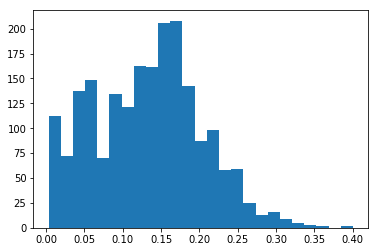

In [14]:
plt.hist(df_daily['RunSampEnt_onLastTsOfEachLevel'].dropna(),bins='auto');

In [ ]:
for h in df_daily['HenID'].unique():
    for d in df_daily[df_daily['HenID']==h]['level'].unique():
        v = df_daily[(df_daily['HenID']==h) & (df_daily['level']==d)]['RunSampEnt_onLastTsOfEachLevel'].values[0]
        if v>0.25:
            entropy_type = 'ts_highEntropy'
        elif v<0.05:
            entropy_type = 'ts_lowEntropy'
        else:
            entropy_type = 'ts_middleEntropy'
        path_ = os.path.join(path_extracted_data,'visual','TimeSeriesPlot', entropy_type)
        #create a director if not existing
        if not os.path.exists(path_):
            os.makedirs(path_)
        df_plt = df_ts[(~df_ts[h].isnull()) & (df_ts['day']==d)].sort_values(['New_Timestamp']).copy()
        df_plt[h] = df_plt[h].map(lambda x: int(dico_zone_order[x]))
        plt.plot(df_plt[h].tolist());
        plt.title(str(d)+'_'+h+'_'+str(v))
        plt.savefig(os.path.join(path_, id_run+'_'+str(d)+'_'+h+'.png'), dpi=300, format='png', bbox_inches='tight')      
        plt.close()

In [16]:
df = pd.read_csv(os.path.join(path_extracted_data, 'Laura_allData.csv'), sep=';', parse_dates=['level']) 
#df_ts['day'] = df_ts['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
display(df.head(3))

,HenID,level,duration_1.Zone,duration_2.Zone,duration_3.Zone,duration_4.Zone,duration_5.Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,RunSampEnt_onLastTsOfEachLevel,RunDistEnt_onLastTsOfEachLevel,RunEnt_onLastTsOfEachLevel_nbr_value,RunEnt_onLastTsOfEachLevel_ts_value
0,10_29,2020-06-08,2820,37320,11400,2040,420,54000,15,0.192542,0.899397,900,2020-06-08 07:00:00
1,10_29,2020-06-09,540,38400,12720,2340,0,54000,15,0.196216,0.843281,1800,2020-06-09 07:01:00
2,10_29,2020-06-10,300,37380,13920,2100,300,54000,15,0.204204,0.829554,2700,2020-06-10 06:54:00


In [17]:
len(df[df['HenID']=='10_29']['RunSampEnt_onLastTsOfEachLevel'].tolist())

21

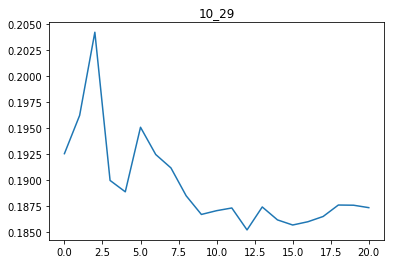

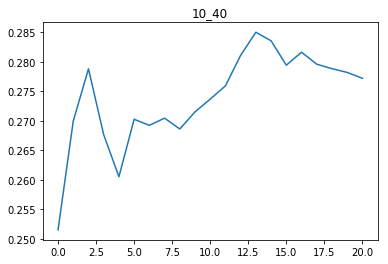

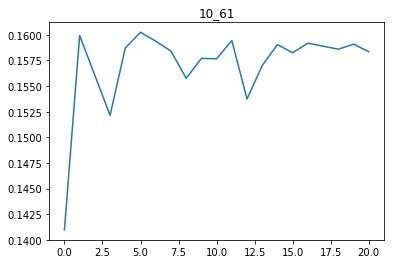

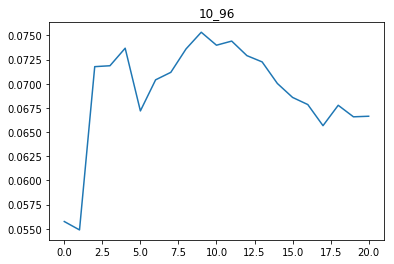

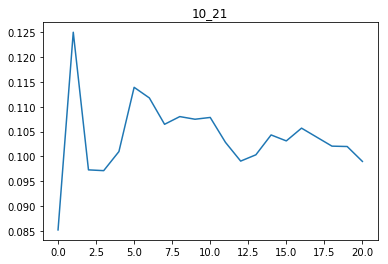

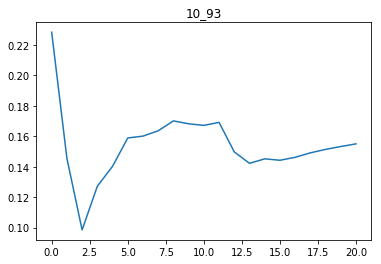

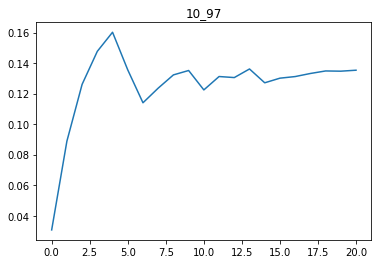

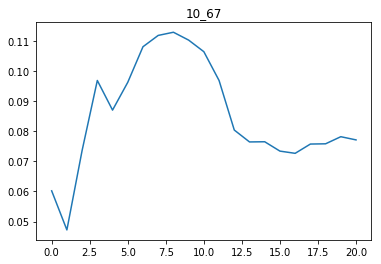

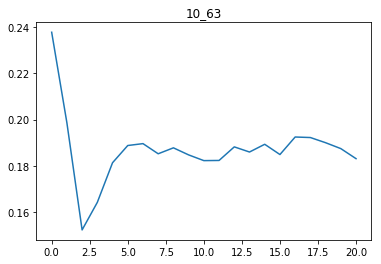

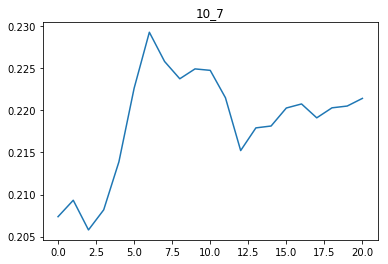

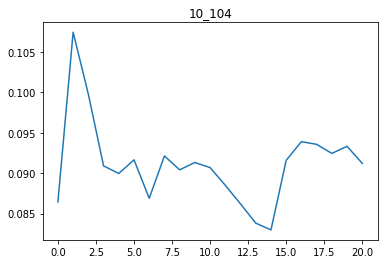

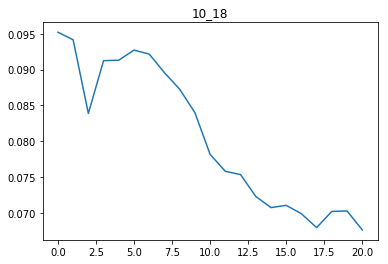

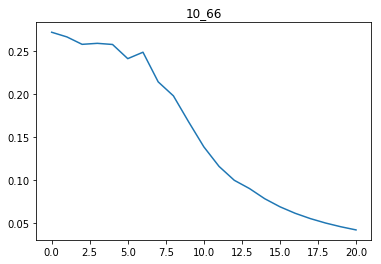

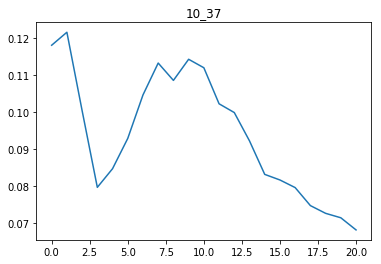

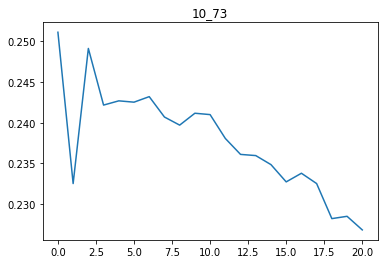

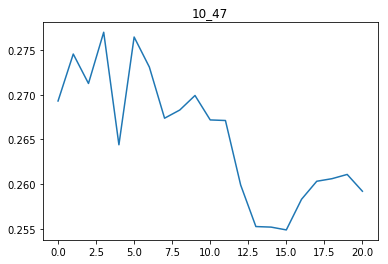

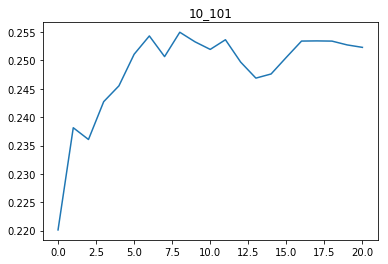

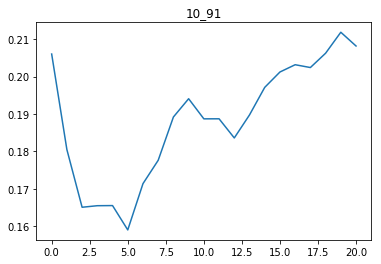

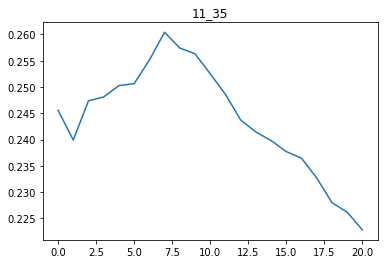

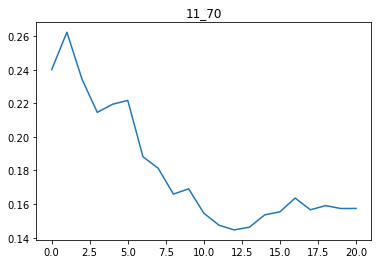

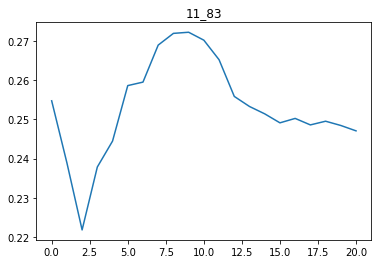

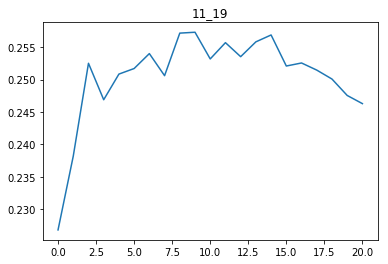

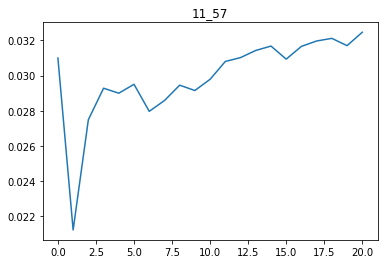

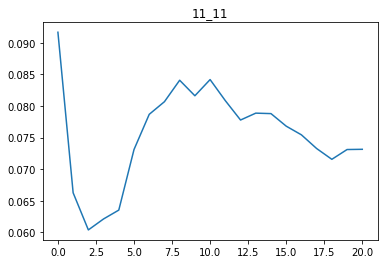

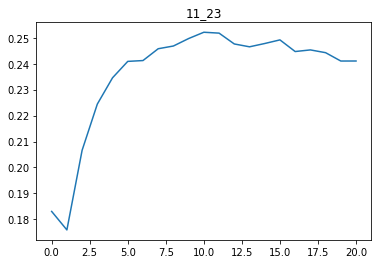

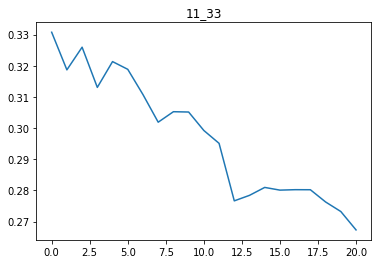

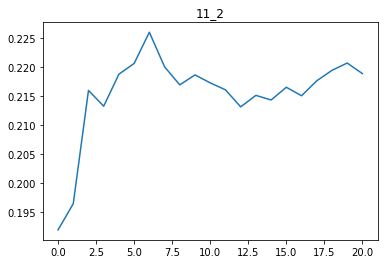

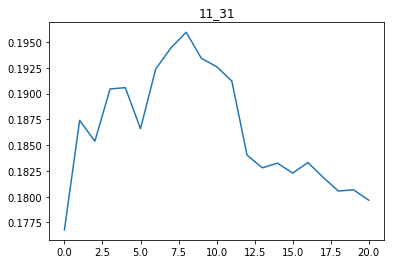

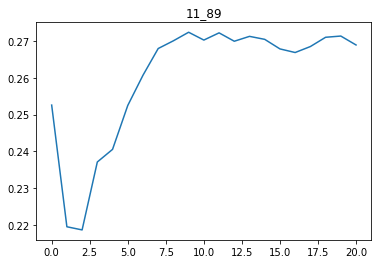

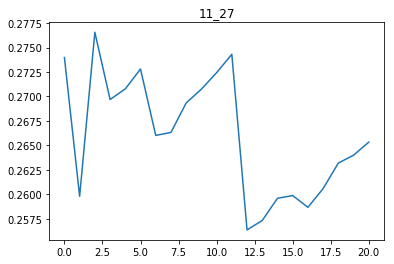

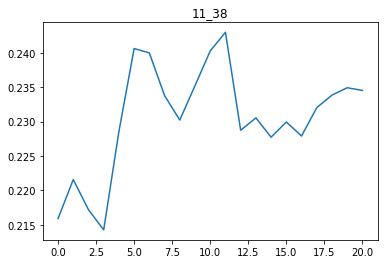

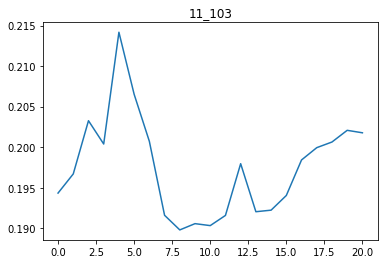

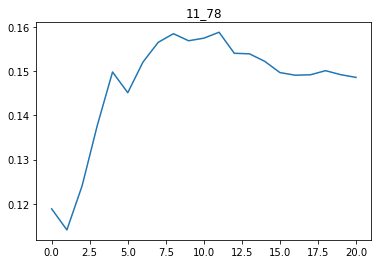

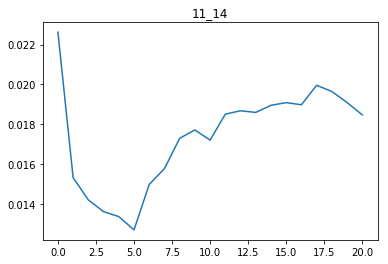

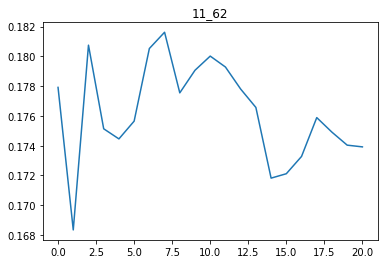

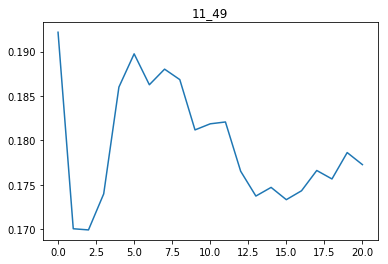

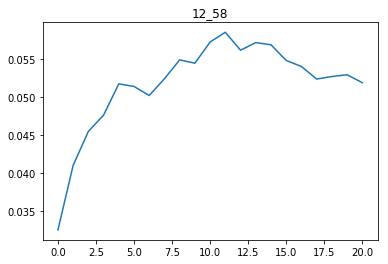

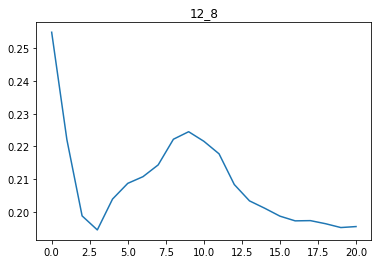

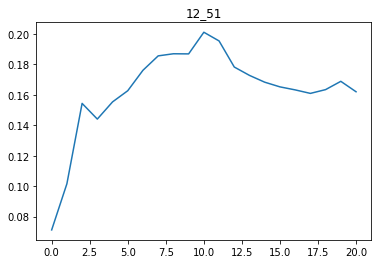

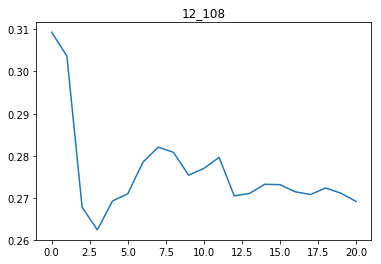

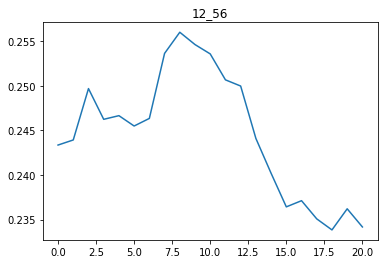

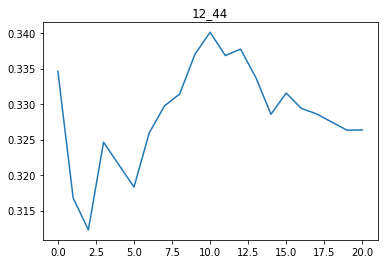

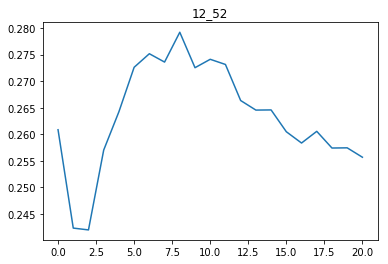

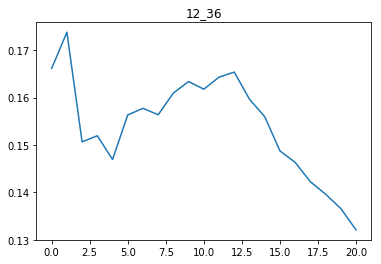

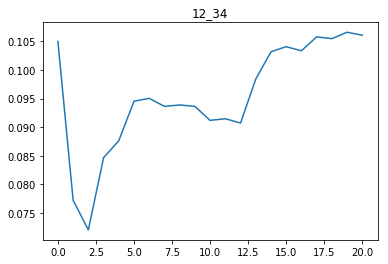

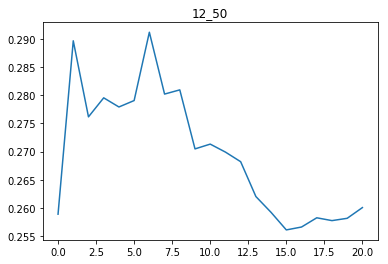

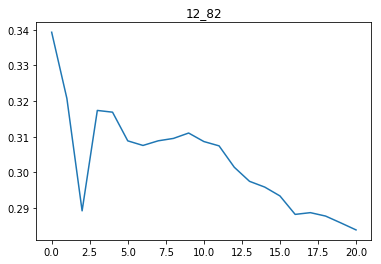

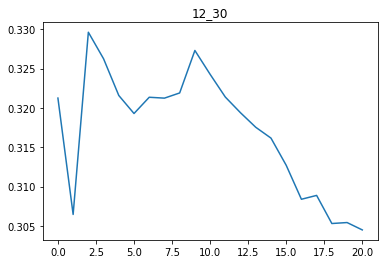

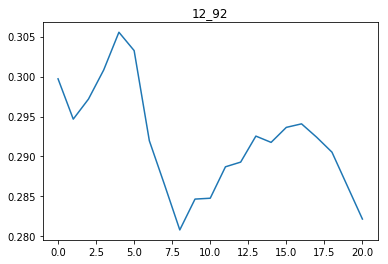

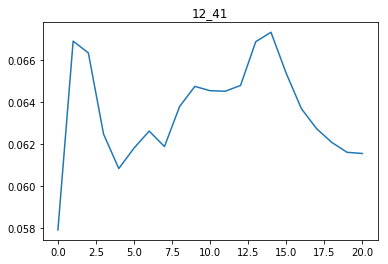

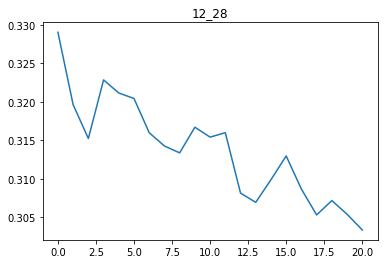

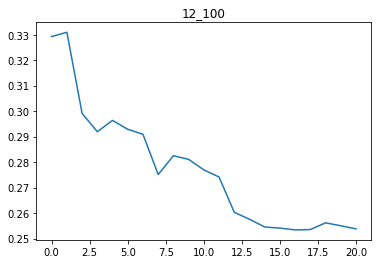

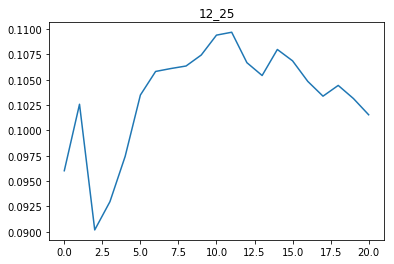

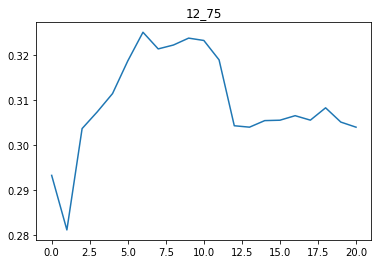

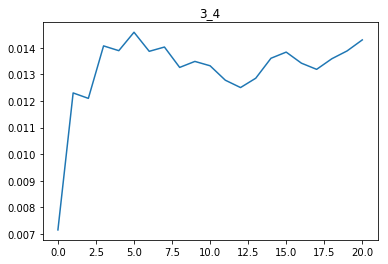

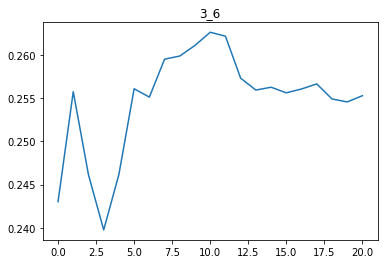

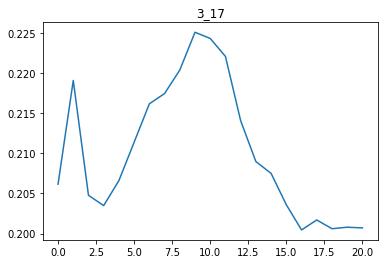

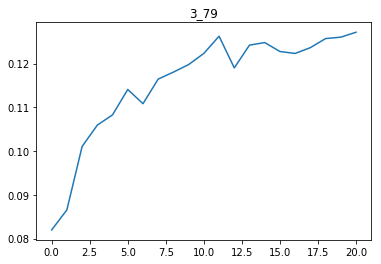

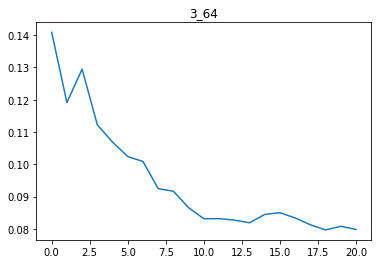

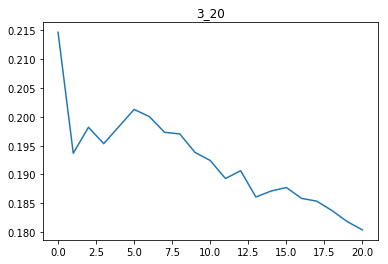

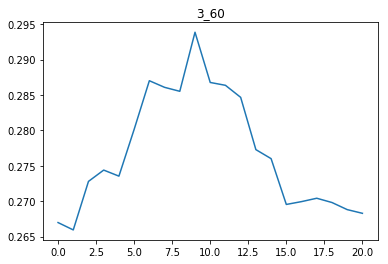

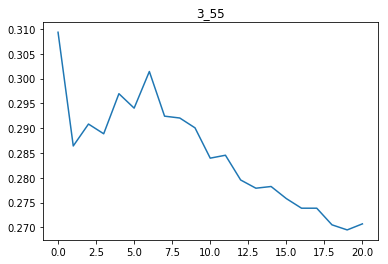

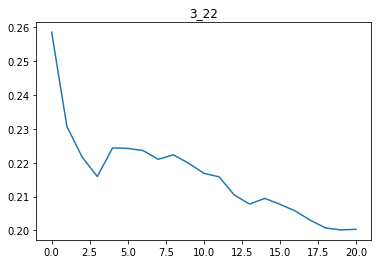

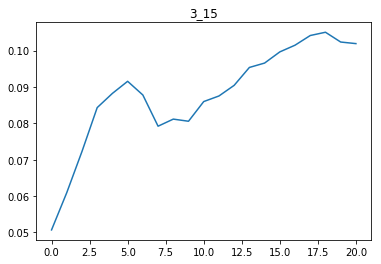

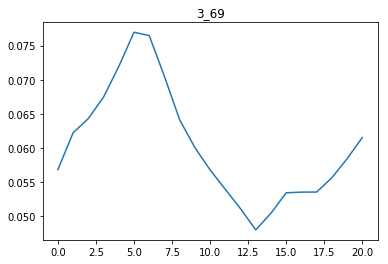

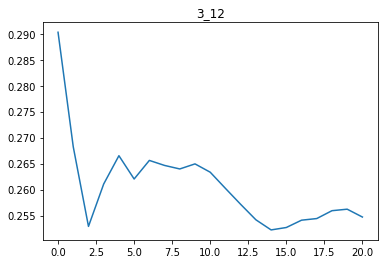

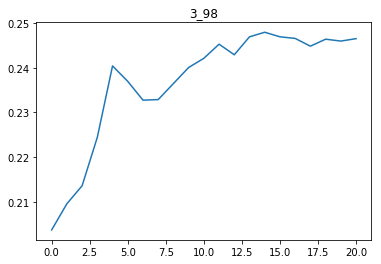

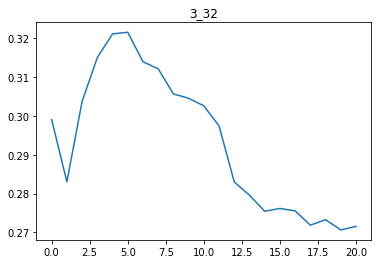

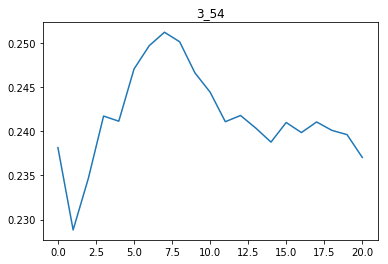

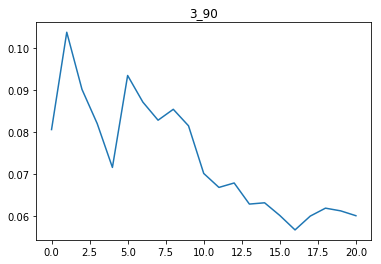

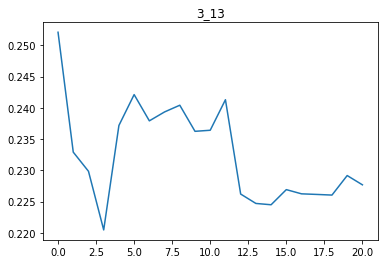

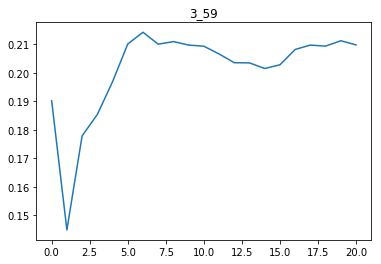

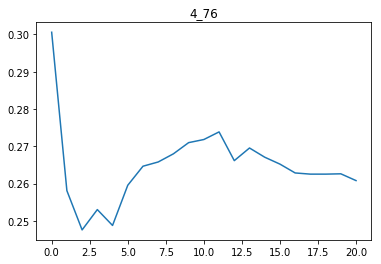

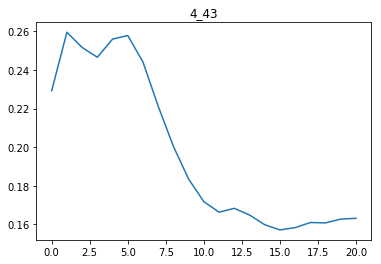

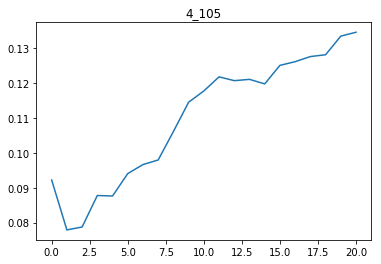

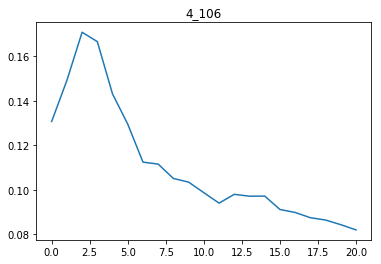

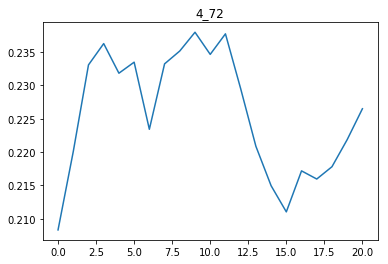

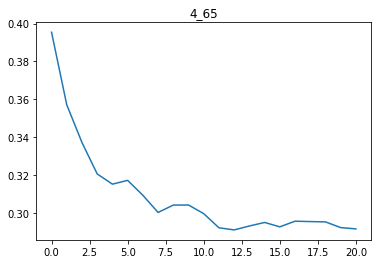

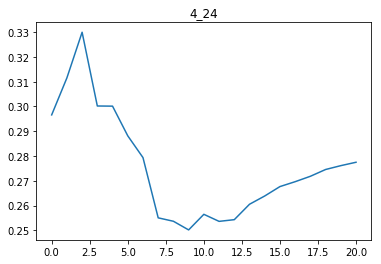

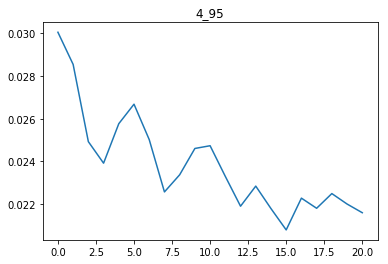

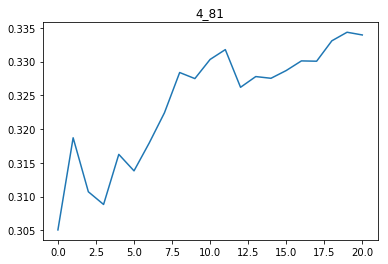

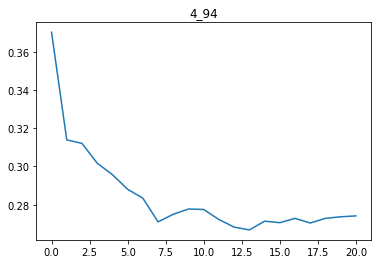

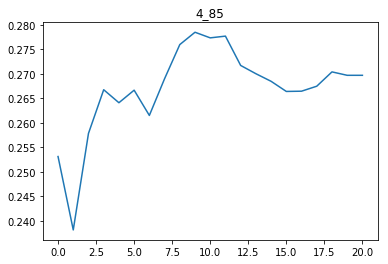

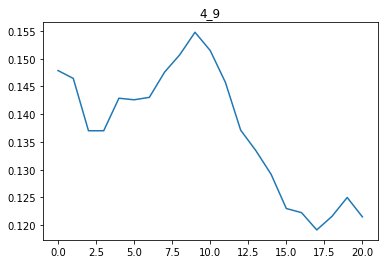

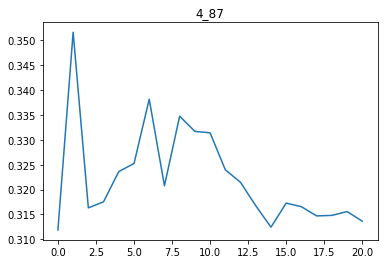

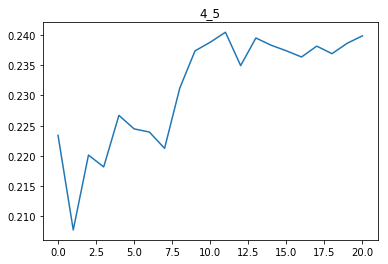

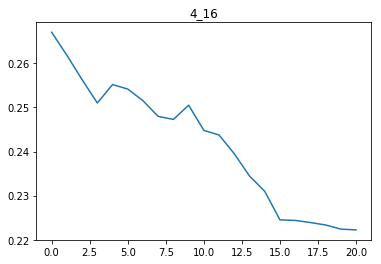

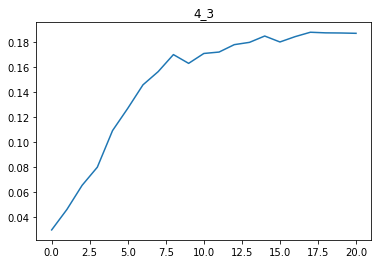

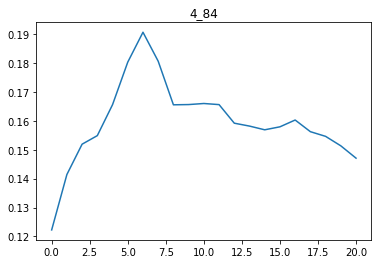

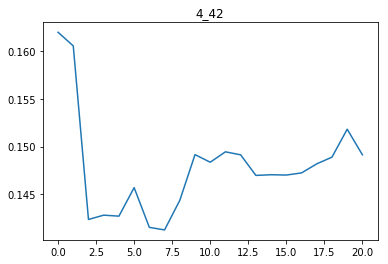

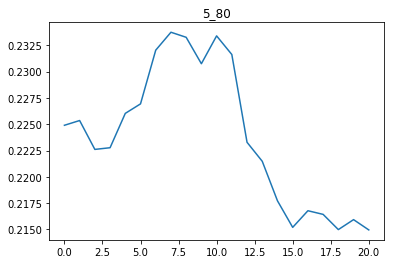

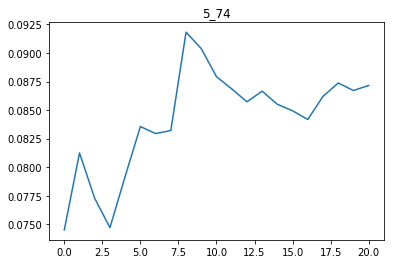

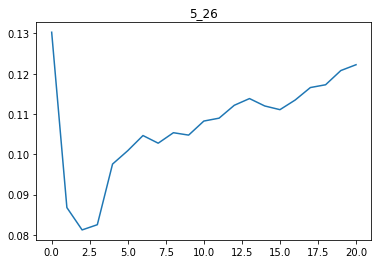

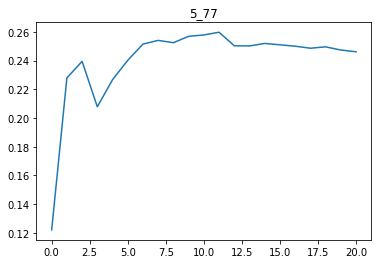

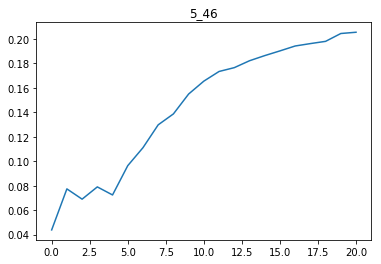

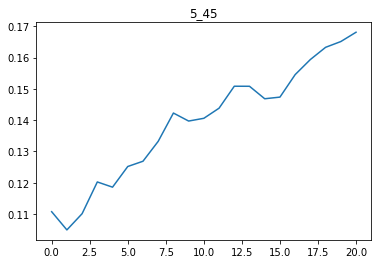

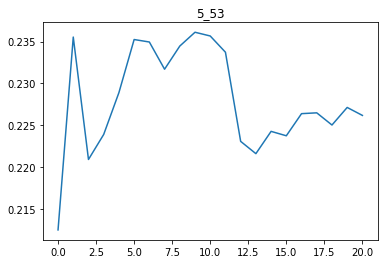

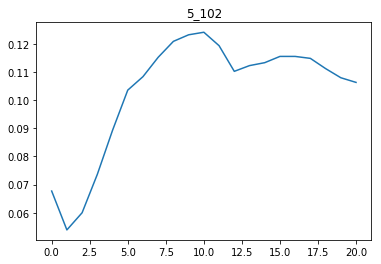

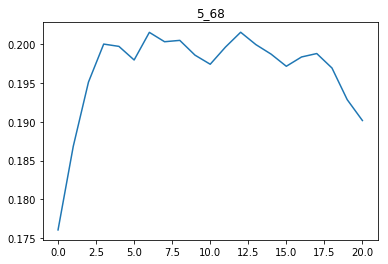

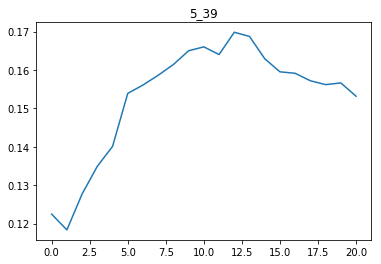

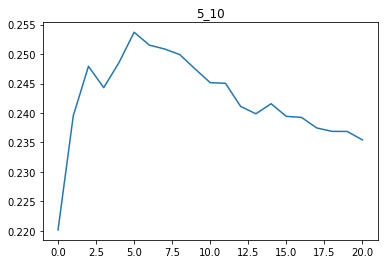

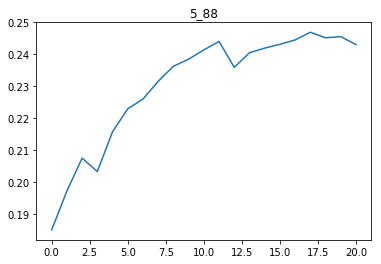

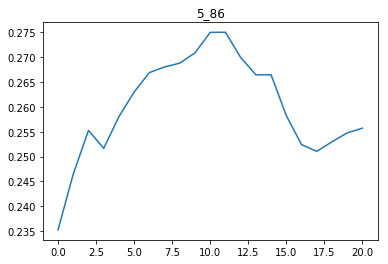

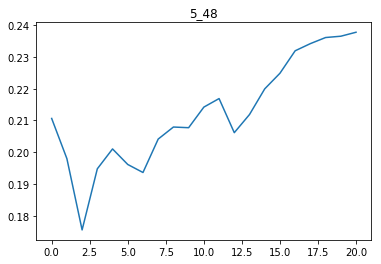

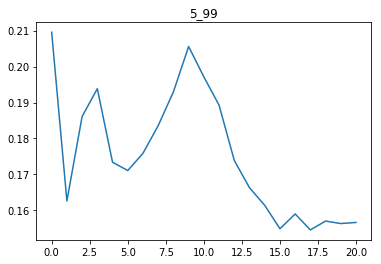

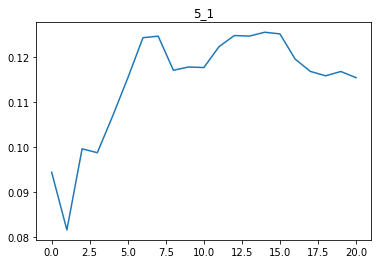

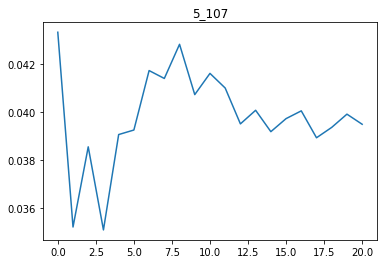

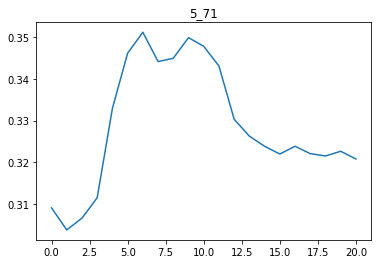

In [18]:
for h in df['HenID'].unique():
    plt.plot(df[df['HenID']==h].sort_values('level', ascending=True)['RunSampEnt_onLastTsOfEachLevel'].tolist());
    plt.title(h)
    plt.show();
    #plt.savefig(os.path.join(path_extracted_data,'visual','TimeSeriesPlot', 'running entropy', h+'.png'))
    plt.close()

In [ ]:
plt.plot(df[df['HenID']==h].sort_values('level', ascending=True)['RunSampEnt_onLastTsOfEachLevel'].tolist());

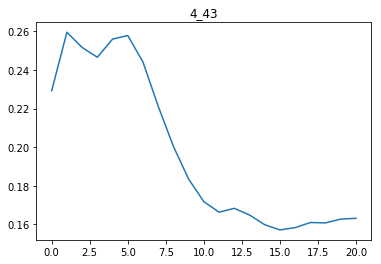

In [19]:
plt.plot(df[df['HenID']=='4_43'].sort_values('level', ascending=True)['RunSampEnt_onLastTsOfEachLevel'].tolist());
plt.title('4_43')
plt.show();
#plt.savefig(os.path.join(path_extracted_data,'visual','TimeSeriesPlot', 'running entropy', h+'.png'))
plt.close()